# TP8 - Modelos de lenguaje y sistemas de recomendación

In [73]:
#librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Modelo de Lenguaje

## Funciones

In [74]:
# Funciones

# Retorna el texto dado, con los espacios unificados y en minúsculas
def processing_text (text):

    #Se separan las palabras por espacios
    words_list = text.split() 

    #Se concatenan las palabras agregando un único espacio
    text_unified = " ".join(words_list) 

    #Se pasan los caracteres a minuscula
    text_unified = text_unified.lower()

    return text_unified


# Retorna la similitud coseno entre los vectores u y v
def SC (u,v) :
    abs_u = np.linalg.norm(u)
    abs_v = np.linalg.norm(v)

    prod = u@v

    return prod/(abs_u * abs_v)

## Clases

In [75]:
# Clases

class semantic_search ():
        
    def __init__(self, model_name='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'):

        #Modelo de lenguaje a usar
        self.model = SentenceTransformer(model_name)

        #Embeddings del texto
        self.embeddings = None
        self.texts = None

    def fit(self, text_list):
        #Se carga la lista de strings
        self.texts = text_list

        print('self.texts', len(self.texts))

        #Se computan los embeddings de la lista de strings dadas
        self.embeddings = self.model.encode(self.texts)

        print('self.embeddings', self.embeddings.shape)

    def search(self, query, k=5):

        #Se computa el embedding del texto buscado
        query_emb = self.model.encode(query)

        # print('query_emb:',query_emb.shape)

        #Se calcula la similitud coseno entre cada embedding del texto almacenado y el del solicitado
        sims = np.array([SC(e, query_emb) for e in self.embeddings])

        # print('sims', sims.shape)

        #Se ordenan de mayor a menor los primeros k indices de los embeddings similares
        idxs = np.argsort(sims)[::-1][:k]

        # print(idxs.shape)

        #Se obtienen los primeros k textos y similitudes, ordenadas de mayor a menor
        ranked_texts = [self.texts[i] for i in idxs]
        ranked_sims = np.array([sims[i] for i in idxs])

        #Se retornan por separado los textos y las similitudes
        return ranked_texts

## Procesamiento de datos

#### Carga de datos y preprocesamiento de los mismos

In [76]:
filename = 'anime.csv'
df = pd.read_csv(filename, sep=',' ) #, nrows=10)

print('df:', df.shape)

#Se obtienen los titulos
titles = df['title']

#Se procesan los titulos para eliminar espacios y pasar todo a minusculas
titles_processed = [processing_text(titles[i]) for i in range(df.shape[0])]

#Se vuelven a cargar los titulos en la columna de titulos del df
df['title'] = titles_processed

print('df:', df.shape)

df: (2966, 1001)
df: (2966, 1001)


#### Modelo de lenguaje

In [77]:
language_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# El modelo toma el texto, lo separa en tokens y reemplaza cada token por un ID entero del vocabulario que posee
# Tras esto, realiza un 'pooling', que puede ser un promedio, para dar el array final de 1x768
embeddig_att =language_model.encode(processing_text('Attack on Titan'))

#Se inicializa el modelo de búsqueda semántica
ss_model = semantic_search()

#Se entrena el modelo de búsqueda semántica, utilizando los títulos
ss_model.fit(df['title'].to_list())

#Se obtienen los 15 titulos más semejantes al query 'Giant' y su similitud coseno
texts = ss_model.search(query = 'Giant', k=15)

print(texts)
# print('sims', sims.shape)

self.texts 2966
self.embeddings (2966, 768)
['giant killing', 'giant beasts of ars', 'megane-bu!', 'megalobox', 'heavy object', 're:monster', 'super hxeros', 'the great warrior wall', 'overlord ii', 'overlord', 'super cub', 'bullbuster', 'plus-sized elf', 'dragon ball super', 'gigant big-shot tsukasa']


# Sistema de recomendación

## Hallar el gradiente del riesgo empírico regularizado correspondiente a un filtro colaborativo. Expresar los resultados vectorizados.

En primera instancia, la forma del riesgo empírico regularizado utilizando un filtro colaborativo, es:

$$
J(x, \theta) = 
\frac{1}{2} \sum_{j=1}^{n_{\text{users}}} \sum_{i=1}^{n_{\text{animes}}}
R_{ij}\ \big( \theta_j^\top x_i - y_{ij} \big)^2 
+ \frac{\lambda}{2} 
\left( 
\sum_{i=1}^{n_{\text{animes}}} \|x_i\|_2^2 
+ 
\sum_{j=1}^{n_{\text{users}}} \|\theta_j\|_2^2 
\right)
$$

donde:

$i$ son las filas que corresponden a un anime determinado

$j$ son las columnas que corresponden a un usuario

$y_{ij}$ es la calificación del usuario j para el anime i

$x_i$ es un vector con las características latentes del anime

$\theta_j$ es el vector de preferencias del usuario j

$$
R_{ij} =
\begin{cases}
1, & \text{si el anime está calificado}  \text{      } (y_{ij}) \\
0, & \text{si el anime no está calificado} \text{      } (-1)
\end{cases}
$$<>


Luego, se obtienen los gradientes respecto a $x_i$ y $\theta_j$ (fila y columna fija respectivamente):

$$
\frac{\partial J}{\partial x_i}
=
\sum_{j=1}^{n_{\text{users}}}
R_{ij}\,\big(\theta_j^\top x_i - y_{ij}\big)\,\theta_j
\;+\;
\lambda\, x_i
$$

$$
\frac{\partial J}{\partial \theta_j}
=
\sum_{i=1}^{n_{\text{animes}}}
R_{ij}\,\big(\theta_j^\top x_i - y_{ij}\big)\,x_i
\;+\;
\lambda\, \theta_j
$$

y por último, la expresión de los gradientes vectorizada es:

$$
\nabla_X J \;=\; \big((X\Theta^\top - Y)\circ R\big)\,\Theta \;+\; \lambda X
$$
$$
\nabla_\Theta J \;=\; \big((X\Theta^\top - Y)\circ R\big)^\top X \;+\; \lambda \Theta
$$


donde: 

$X$ es la matriz de $n_{animes}$ x k donde k son la cantidad de caracteristicas latentes (una fila por anime)

$\Theta$ es la matriz de preferencias de los usuarios, de tamaño $n_{users}$ x k  (una fila por usuario)

$Y$ es la matriz de las calificaciones (de tamaño $n_{animes}$ x $n_{users}$)

$R$ es la matriz de existencia de las calificaciones (vale 1 para las calificadas y 0 cuando está el -1, es decir, sin calificar). Es de tamaño $n_{animes}$ x $n_{users}$

El símbolo "$\circ$" representa el producto Hadamard, es decir, la multiplicación elemento a elemento de matrices de iguales tamaños



## Se agrega un usuario a la base de datos con al menos 10 series calificadas

In [78]:
n_animes = df.shape[0]

df['new_user'] = -1

new_user = {
        ss_model.search(query = 'one punch man season 2', k=2)[0] : 10.0,
        ss_model.search(query = 'one punch man season 3', k=2)[0] : 10.0,
        ss_model.search(query = 'one punch man', k=2)[0] : 10.0,
        ss_model.search(query = 'dragon ball super', k=2)[0] : 10.0,
        ss_model.search(query = 'dragon ball z', k=2)[0] : 10.0,
        ss_model.search(query = 'one room', k=2)[0] : 10.0,
        ss_model.search(query = 'one room second season', k=2)[0] : 10.0,
        ss_model.search(query = 'one room third season', k=2)[0] : 10.0,
        ss_model.search(query = 'one piece', k=2)[0] : 10.0,
        ss_model.search(query = 'orient', k=2)[0] : 10.0,
}

for title, rating in new_user.items():
        mask = df['title'] == title
        if mask.any():
                df.loc[mask, 'new_user' ] = rating


print(df['new_user'].iloc[646])
print(df['title'].iloc[646])

# #Se asigna la cantidad de animes calificados
# n_rated = 10
# 
# #Se seleccionan n_rated posiciones aleatorias, sin reposición
# valid_positions = np.random.choice(
#     n_animes,
#     size=n_rated,
#     replace=False
# )


# #Se cargan en las posiciones seleccionadas, n_rated calificaciones
# min_rating = 0
# max_rating = 10

# new_user[valid_positions] = np.random.randint(min_rating, max_rating+1 ,size=n_rated)

#Se obtiene el ID del último usuario
# last_user_id = int(df.columns[-1])

# #Se obtiene el ID del nuevo usuario como el ID del último +1
# new_user_id = str(last_user_id + 1)

# #Se carga la columna con las calificaciones del nuevo usuario
# df[new_user_id] = new_user

# print(df.columns[0])

10
dragon ball super


## Filtro colaborativo

#### Funciones

In [79]:
#Función para entrenar un filtro colaborativo
def train_filter(Y, k=15, lam=10.0, lr=1e-3, n_iters=2500, seed=509, normalize=True):

    #Conversión a Array de numpy
    Y=Y.values

    #Se carga la semilla en el generador pseudoaleatorio
    np.random.seed(seed)

    #Se obtiene la cantidad de animes y de usuarios según el shape del dataset
    n_animes, n_users = Y.shape

    #Se construye la matriz R, con 1 si hay calificación y 0 si no la hay (es decir, hay un -1)
    R = (Y != -1).astype(float)

    if normalize: #Se normaliza entre [0,1] las calificaciones
        Y = Y/10.0
        
    #Se inicializa el gradiente con valores aleatorios pequeños para X y Theta. Ambos de dimensión latente k
    X = 0.01 * np.random.randn(n_animes, k)
    Theta = 0.01 * np.random.randn(n_users, k)

    #Se sustituye por 0 cuando hay un -1 para evitar problemas
    Y_filled = np.where(R == 1, Y, 0.0)


    losses = []
    for it in range(1, n_iters + 1):
        
        #Se calcula la aproximación de la predicción actual
        pred = X @ Theta.T
        err = (pred - Y_filled) * R 

        #Se calculan los gradientes para x y para theta según las ecuaciones
        grad_X = err @ Theta + lam * X
        grad_Theta = err.T @ X + lam * Theta

        #Se actualiza X y Theta para el gradiente, usando el learning rate
        X -= lr * grad_X
        Theta -= lr * grad_Theta

        #Se calcula el riesgo empírico regularizado
        loss_data = 0.5 * np.sum((err)**2)
        loss_reg = 0.5 * lam * (np.sum(X**2) + np.sum(Theta**2))
        loss = loss_data + loss_reg
        losses.append(loss)

    return X, Theta, losses


#Función para graficar el riesgo empírico en función de las iteraciones
def plot_losses(losses,n_iters):
    iters = np.linspace(0,n_iters,len(losses))
    plt.figure(figsize=(6,4))
    plt.plot(iters,losses)
    plt.xlabel("Iteraciones")
    plt.ylabel("Riesgo empirico regularizado")
    plt.title("Riesgo empírico vs iteraciones")
    plt.grid(True)
    plt.tight_layout()
    
#Función para obtener la media de las calificaciones hechas por cada usuario (solo se contemplan las calificadas)
def rating_mean(Y):

    #Se construye la matriz R, con 1 si hay calificación y 0 si no la hay (es decir, hay un -1)
    R = (Y != -1).astype(float)

    #Se multiplica el df por R que es la máscara y suma por filas
    sums = (Y * R).sum(axis=1)

    #Se cuenta la cantidad de usuarios que calificaron cada anime
    counts = R.sum(axis=1)

    #Se crea un array de ceros de igual forma y tipo que sums
    means = np.zeros_like(sums)

    #Se toman los animes que tuvieron al menos 1 calificación
    nonzero = counts > 0

    #Se carga el array de medias para los animes con al menos 1 calificación
    means[nonzero] = sums[nonzero] / counts[nonzero]

    return means

#Función para recomendar los k mejores animes con mayor rating
def recommend_top_k(Y, X, Theta, user_idx, k_top=15, alpha=0.75):

    #Conversión a Array de numpy
    Y=Y.values

    #Se calcula la predicción utilizando las caracteristicas X
    pred = X @ Theta.T
    
    #Se construye la matriz R, con 1 si hay calificación y 0 si no la hay (es decir, hay un -1)
    R = (Y != -1).astype(float)

    #Se obtiene la media de calificaciones para cada anime
    anime_means = rating_mean(Y)

    #Se calcula la calificación para el usuario utilizando el filtro colaborativo, considerando también la predicción hecha
    # para el mismo sobre los animes, usando pesos complementarios
    rating_user = alpha * pred[:, user_idx] + (1 - alpha) * anime_means

    #Se obtiene el filtro de los animes no vistos para el usuario 
    not_seen = (R[:, user_idx] == 0)

    #Se guardan los animes no vistos por el usuario
    candidates_idx = np.where(not_seen)[0]

    #Se guardan los índices de los k animes mejor rankeados, de mayor a menor
    top_idx = np.argsort(rating_user[candidates_idx])[::-1][:k_top]

    return candidates_idx[top_idx], rating_user[candidates_idx][top_idx]


#### 

#### Gráfico del riesgo empírico vs iteraciones

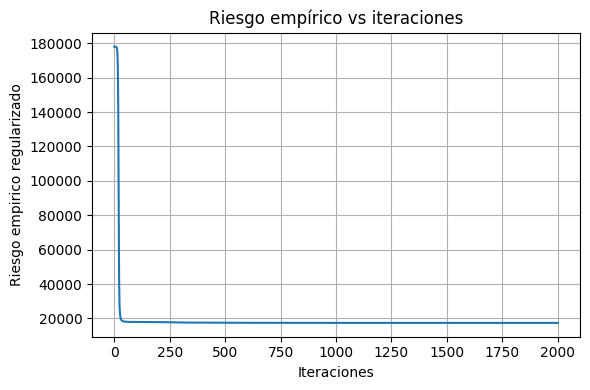

In [80]:
if 'title' in df.columns:
    df_modified = df.drop('title', axis=1)

n_iters = 2000

X,Theta, losses = train_filter(df_modified, n_iters=n_iters)

plot_losses(losses,n_iters=n_iters)

#### Top 10 de animes recomendados para el usuario

In [81]:
user_idx = df_modified.shape[1] - 1

candidates_idx, rating_user = recommend_top_k(df_modified, X, Theta, user_idx= user_idx, k_top=10)


top_titles = df['title'].iloc[candidates_idx]


#Se calcula la predicción utilizando las caracteristicas X
pred = X @ Theta.T

# print(pred)
# print(df)





print(f'Top 10 de animes recomendados para el usuario {df_modified.columns[-1]}:\n', top_titles)

Top 10 de animes recomendados para el usuario new_user:
 2487              the fragrant flower blooms with dignity
383                                    bukiyou na senpai.
237                                              bad girl
2918            yozakura-san chi no daisakusen 2nd season
2132                  scooped up by an s-rank adventurer!
122                                        ame to kimi to
2675              tomodachi no imouto ga ore ni dake uzai
2196    shinjiteita nakama-tachi ni dungeon okuchi de ...
979     hell mode: yarikomizuki no gamer wa hai settei...
1655                        my hero academia final season
Name: title, dtype: object
